This script looks at timelagged isoprene autocorrelations and computes an augmented Dickey-Fuller test for stationarity.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

In [38]:
def bair_data_read_in(site_dir:str):
    df_lst = []
    for file in os.listdir(site_dir):
        try:
            df = pd.read_csv(rf'{site_dir}/{file}', header=1)
            df['time'] = pd.to_datetime(df['time'], unit='s')
            df['time'] = df['time'].dt.round('min')
            df_lst.append(df)
        except:
            pass
    data = pd.concat(df_lst)
    data = data.sort_values('time')
    try:
        data = data.rename(columns={'wsp_avg_ms': 'wsp', 'wdr_avg': 'wdr'})
    except AttributeError:
        pass
    if 'met' in site_dir:
        data = data[['time', 'wsp', 'wdr', 'temp_f']]
    else:
        data = data[['time', 'isoprene']]
    return data

In [39]:
isoprene = bair_data_read_in(r'/Users/gabegreenberg/Boulder_AIR/BoulderAIR_data/LUR/voc')
print(isoprene)

                    time  isoprene
0    2020-02-01 00:42:00   0.01731
1    2020-02-01 02:06:00   0.01313
2    2020-02-01 03:31:00   0.01731
3    2020-02-01 04:55:00   0.01851
4    2020-02-01 06:20:00   0.01373
...                  ...       ...
1023 2025-02-19 00:05:00   0.00504
1024 2025-02-19 01:05:00   0.00504
1025 2025-02-19 02:05:00   0.00504
1026 2025-02-19 03:05:00   0.00504
1027 2025-02-19 04:05:00   0.00504

[40055 rows x 2 columns]


/var/folders/2c/kht9wb5n56xdj4mxjj2k7twr0000gn/T/ipykernel_4734/3962584654.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  isoprene['time'] = isoprene['time'].dt.round('H')
/var/folders/2c/kht9wb5n56xdj4mxjj2k7twr0000gn/T/ipykernel_4734/3962584654.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  isoprene_impute = isoprene.resample('H').mean()


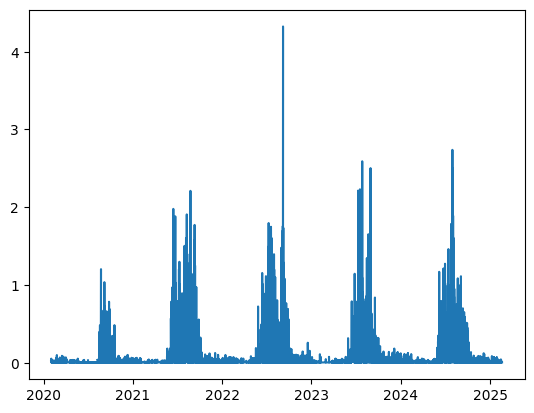

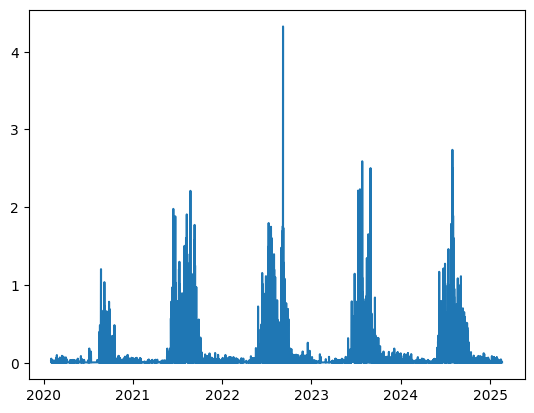

0.04434617718621399
0.042896752856562186


In [40]:
isoprene['time'] = isoprene['time'].dt.round('H')
isoprene.set_index('time', inplace=True)

# imputting the data to ensure regular spacing 
isoprene_impute = isoprene.resample('H').mean()
isoprene_impute['isoprene'] = isoprene_impute['isoprene'].interpolate(method='linear')
isoprene_impute = isoprene_impute.reset_index()
isoprene = isoprene.reset_index()

plt.plot('time', 'isoprene', data = isoprene)
plt.show()

plt.plot('time', 'isoprene', data = isoprene_impute)
plt.show()

print(np.mean(isoprene['isoprene']))
print(np.mean(isoprene_impute['isoprene']))
# I plotted to and printed out the mean as a quick check to make sure the imputation didn't impact the data a huge ammount.

In [41]:
isoprene = isoprene_impute

In [42]:
# make monthly average data set
isoprene.set_index('time', inplace=True)
monthly_isoprene = isoprene.resample('m').mean()
monthly_isoprene = monthly_isoprene.reset_index()
isoprene = isoprene.reset_index()
print(monthly_isoprene)

         time  isoprene
0  2020-02-29  0.008742
1  2020-03-31  0.008556
2  2020-04-30  0.006049
3  2020-05-31  0.006251
4  2020-06-30  0.007269
..        ...       ...
56 2024-10-31  0.020305
57 2024-11-30  0.014268
58 2024-12-31  0.013187
59 2025-01-31  0.011690
60 2025-02-28  0.006783

[61 rows x 2 columns]


/var/folders/2c/kht9wb5n56xdj4mxjj2k7twr0000gn/T/ipykernel_4734/188563000.py:3: FutureWarning: 'm' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_isoprene = isoprene.resample('m').mean()


In [43]:
# make weekly average dataset
isoprene.set_index('time', inplace=True)
weekly_isoprene = isoprene.resample('w').mean()
weekly_isoprene = weekly_isoprene.reset_index()
isoprene = isoprene.reset_index()
print(weekly_isoprene)

          time  isoprene
0   2020-02-02  0.021922
1   2020-02-09  0.008165
2   2020-02-16  0.006247
3   2020-02-23  0.008157
4   2020-03-01  0.008315
..         ...       ...
260 2025-01-26  0.009684
261 2025-02-02  0.013543
262 2025-02-09  0.006282
263 2025-02-16  0.007826
264 2025-02-23  0.005040

[265 rows x 2 columns]


/var/folders/2c/kht9wb5n56xdj4mxjj2k7twr0000gn/T/ipykernel_4734/586631485.py:3: FutureWarning: 'w' is deprecated and will be removed in a future version, please use 'W' instead.
  weekly_isoprene = isoprene.resample('w').mean()


In [ ]:
# run adf on the whole non averaged isoprene data set I referenced this: https://neptune.ai/blog/arima-sarima-real-world-time-series-forecasting-guide
def adf_tester_func(df):
    '''
    computes the adf test to check for stationarity 

    Args:
        df: isoprene dataframe

    Returns:
        None (it just prints out relivant results from the test)
    '''
    adf_test = adfuller(df["isoprene"].dropna())  
    adf_stat, p_val, i, i, critical_vals, i = adf_test

    print(f"ADF Stat: {adf_stat}")
    print(f"P-Value: {p_val}")
    print(f"Critical Valus: {critical_vals}")
    if p_val < 0.05:
        print("The Isoprene data is stationary.")
    else:
        print("The Isoprene data is not stationary.")

adf_tester_func(isoprene)
# It claims stationarity however, 
# I think this may impart be because of how many data points their are, 
# because variance and the mean do change a lot depending on if its isoprene season or not


ADF Stat: -12.870559223537523
P-Value: 4.8895443718229356e-24
Critical Values: {'1%': np.float64(-3.430497859539337), '5%': np.float64(-2.861605350691843), '10%': np.float64(-2.5668047840446397)}
The Isoprene data is stationary.


(-0.1, 1.0)

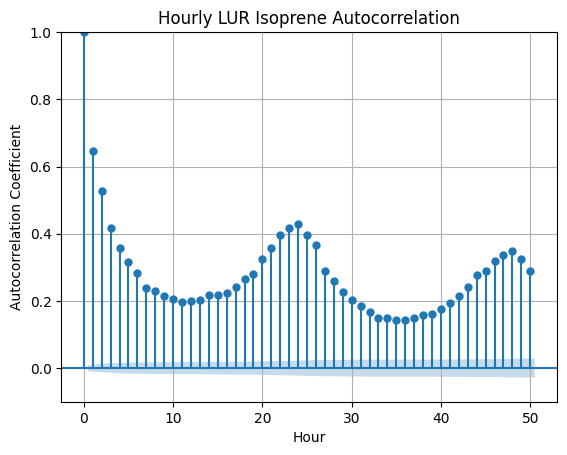

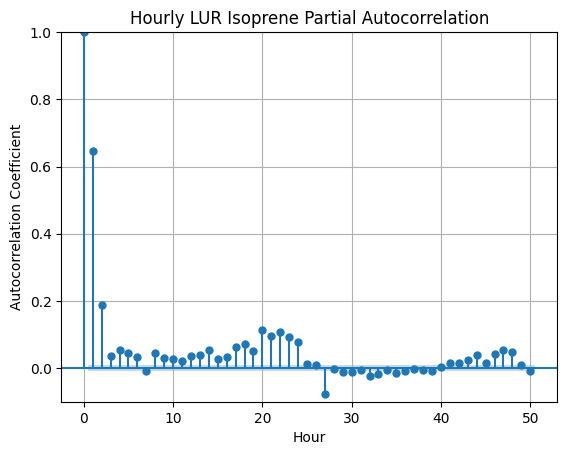

In [45]:
# 50 (>48) laggs were used to check 2 dayly ossolations
plot_acf(isoprene['isoprene'], lags=50)  
plt.ylim(-.1, 1)
plt.title('Hourly LUR Isoprene Autocorrelation')
plt.xlabel('Hour')
plt.ylabel('Autocorrelation Coefficient')
plt.grid()

plot_pacf(isoprene['isoprene'], lags=50) 
plt.title('Hourly LUR Isoprene Partial Autocorrelation')
plt.xlabel('Hour')
plt.ylabel('Autocorrelation Coefficient')
plt.grid()
plt.ylim(-.1, 1)


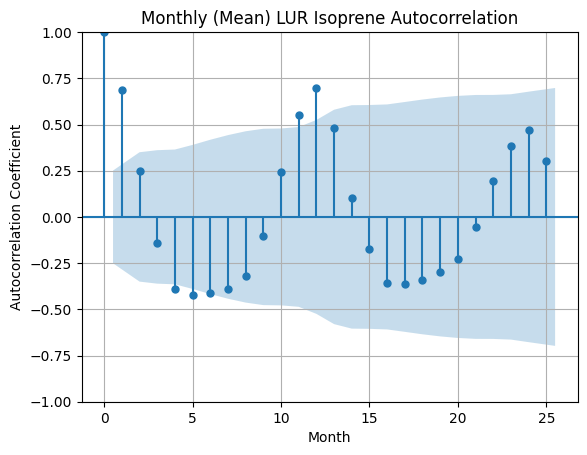

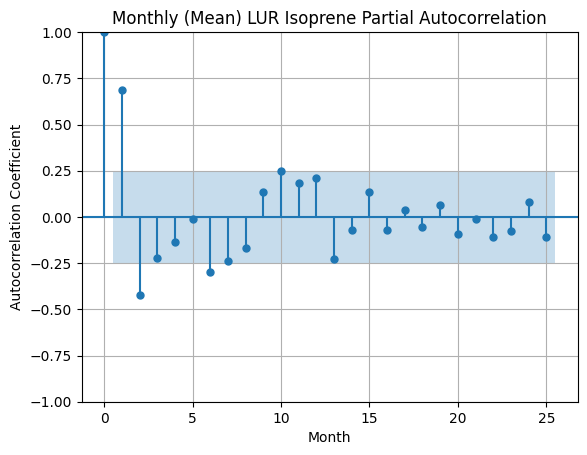

In [46]:
# 25 (>24) laggs were used to check 2 yearly ossolations
plot_acf(monthly_isoprene['isoprene'], lags=25)  
plt.title('Monthly (Mean) LUR Isoprene Autocorrelation')
plt.xlabel('Month')
plt.ylabel('Autocorrelation Coefficient')
plt.grid()

plot_pacf(monthly_isoprene['isoprene'], lags=25) 
plt.title('Monthly (Mean) LUR Isoprene Partial Autocorrelation')
plt.xlabel('Month')
plt.ylabel('Autocorrelation Coefficient')
plt.grid()


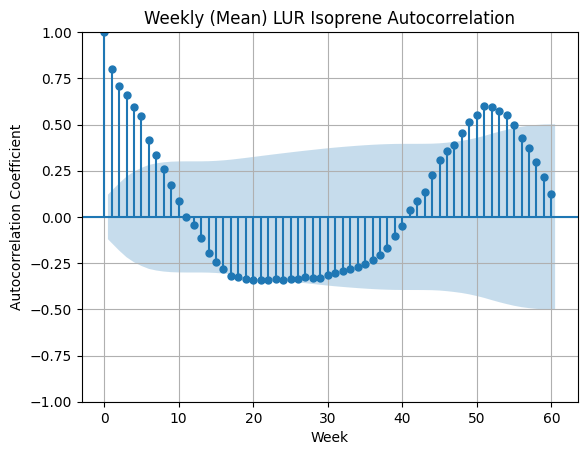

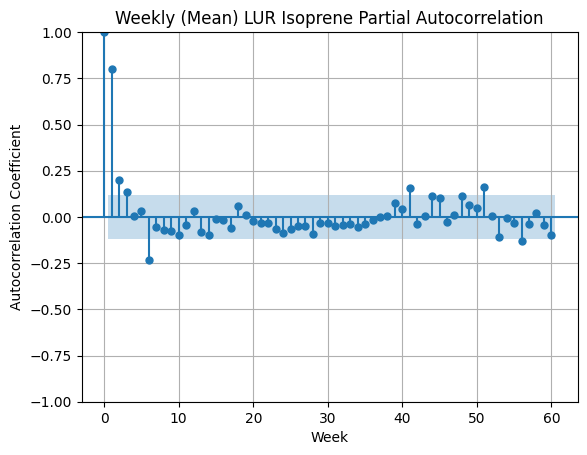

In [47]:
# 60 (> 52) laggs were used to check 1 yearly ossolation
plot_acf(weekly_isoprene['isoprene'], lags=60)  
plt.title('Weekly (Mean) LUR Isoprene Autocorrelation')
plt.xlabel('Week')
plt.ylabel('Autocorrelation Coefficient')
plt.grid()

plot_pacf(weekly_isoprene['isoprene'], lags=60) 
plt.title('Weekly (Mean) LUR Isoprene Partial Autocorrelation')
plt.xlabel('Week')
plt.ylabel('Autocorrelation Coefficient')
plt.grid()